In [2]:
# Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

%matplotlib inline


In [3]:
# Utility functions
def neg_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

In [4]:
# Load and preprocess data
df = pd.read_csv('data/bench.csv')

network_time = 200
df['duration_without_network'] = df['duration'] - network_time
df['dpc_net'] = df['duration_without_network'] / df['char_count']

In [6]:
# Analyze highest character count entries
df_sorted = df.sort_values('char_count', ascending=False)
print("Top 3 entries with highest character count:")
display(df_sorted[['char_count', 'dpc_net', 'target_lang']].head(2))

Top 3 entries with highest character count:


,char_count,dpc_net,target_lang
119,841,1.890606,FR
118,752,2.132979,ES


Trend line slope (increase ratio): 1.7911
Trend line intercept: 360.5227
R-squared: 0.3963
P-value: 0.0000


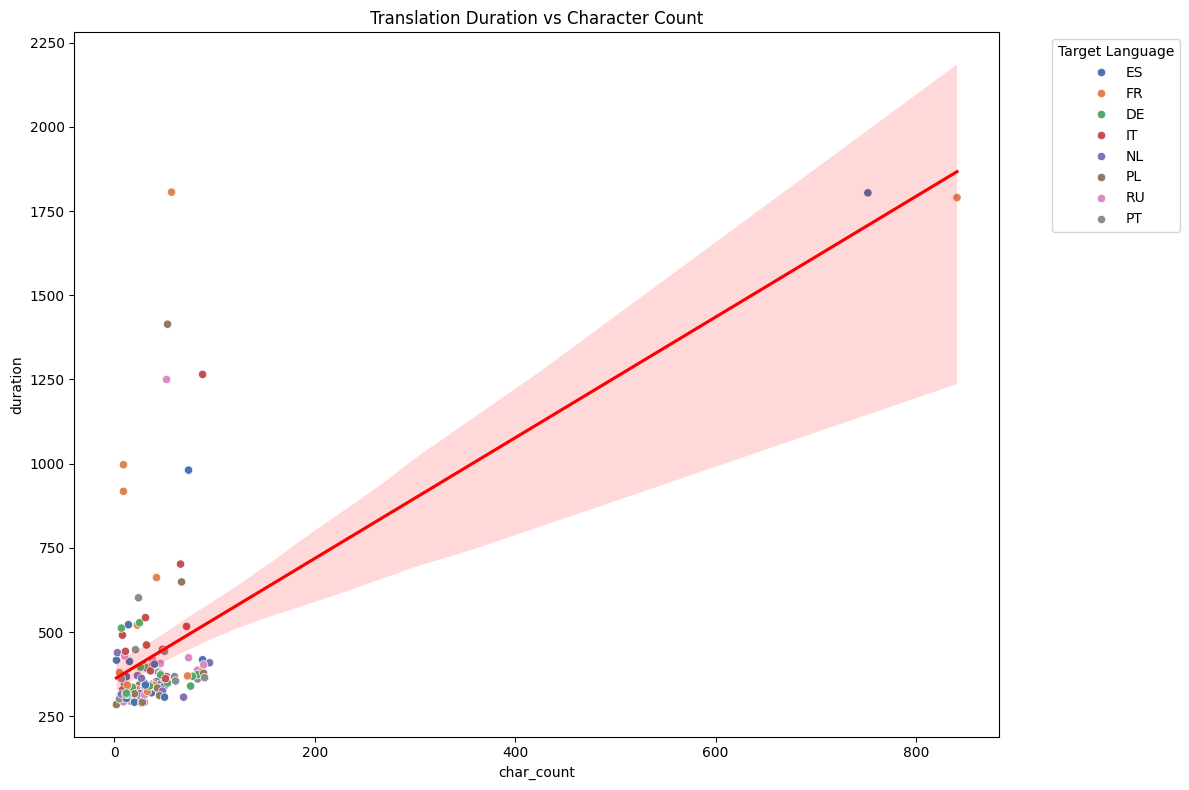

In [8]:
# 1. Plot duration vs char count
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='char_count', y='duration', hue='target_lang', palette='deep')

plt.xlabel('Character Count')
plt.ylabel('Duration (ms)')
plt.title('Translation Duration vs Character Count')

# Add a trend line
sns.regplot(data=df, x='char_count', y='duration', scatter=False, color='red')

slope, intercept, r_value, p_value, std_err = stats.linregress(df['char_count'], df['duration'])

print(f"Trend line slope (increase ratio): {slope:.4f}")
print(f"Trend line intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

plt.legend(title='Target Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

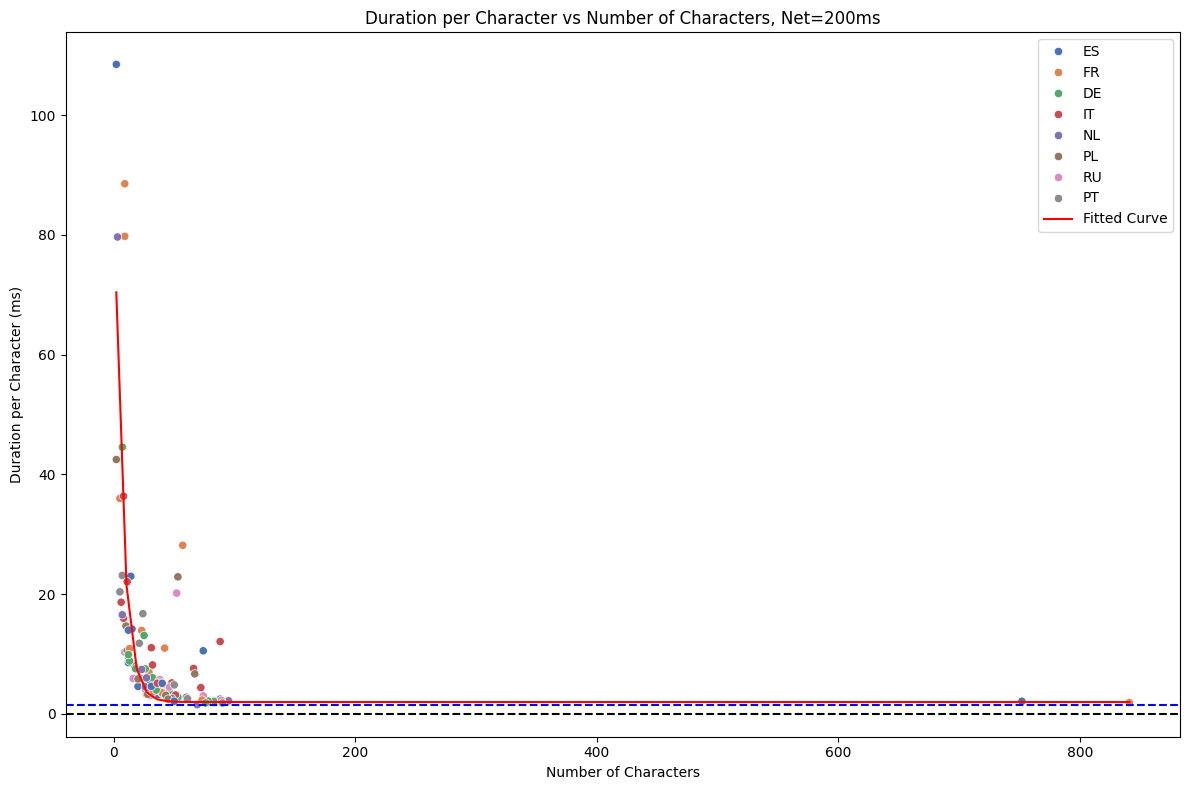

In [19]:
# 2: Plot duration per character vs number of characters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='char_count', y='dpc_net', hue='target_lang', palette='deep')

plt.xlabel('Number of Characters')
plt.ylabel('Duration per Character (ms)')
plt.title(f'Duration per Character vs Number of Characters, Net={network_time}ms')

popt, pcov = curve_fit(neg_exp, df['char_count'], df['dpc_net'], p0=[1, 0.001, 0])

# Initial guess and bounds
p0 = [max(df['dpc_net']) - min(df['dpc_net']), 0.01, min(df['dpc_net'])]
bounds = ([0, 0, 0], [np.inf, np.inf, 2])  # Set upper bound of c to 2 ms

popt, pcov = curve_fit(neg_exp, df['char_count'], df['dpc_net'], p0=p0, bounds=bounds)

x_fit = np.linspace(df['char_count'].min(), df['char_count'].max(), 100)
y_fit = neg_exp(x_fit, *popt)

plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')

# Add line for 0
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()

# Add line for 1.5
plt.axhline(1.5, color='blue', linestyle='--')
plt.tight_layout()

plt.legend()
plt.tight_layout()
plt.show()

# Translation Performance Analysis

## Current Data
I've obtained data using the script `bin/measure_translation_time.rs`. All the data is in `tests/benchmark/bench.csv` and this Jupyter notebook.

## Observations
1. The duration per character decreases as the number of characters increases, which is expected. It seems to get as low as 1.5ms per character. 500k * 1.5ms = 750s = 12.5 minutes.
2. The limit of one single request is 128 KiB, around 130k characters. https://developers.deepl.com/docs/api-reference/translate
3. We would need 750 concurrent requests to translate 500k characters in under 1 second.
4. The actual duration per request is more than 300ms, so we can send up to 3 requests per thread. With 750 concurrent threads, we can send up to 3 * 750 = 2250 requests per second. To translate 500k characters in one second, we would need approximately 500k / 2250 ≈ 222 characters per request.


## Potential Improvements

1. Test how many concurrent request DeepL allow us to use per key.
   - Rationale: [Why you think this might help]
   - Implementation: [Brief notes on how to implement]

2. Use the batch api if there are too many message.
   - Rationale: [Why you think this might help]
   - Implementation: [Brief notes on how to implement]

3. Custom batching,
   - Rationale: If the actual batching endpoint of DeepL is slower, we could join Strings with an special character and then separate them back.
   - Implementation: Use an special character to join them like ~, | or `.O.`, something that won't make the deepL model panic or change the maining of the text.

## Next Steps

1. Implement concurrent request testing to determine DeepL's limits.
2. Build a mock server that emulates the DeepL performance, same number of threads and processing time.
2. Compare performance between single requests and batch API.
3. Develop and test custom batching solution if needed.

In short, maximize threads, reduce number of messages per thread. The theoretical minimum would be one message per thread with as many threads as DeepL allows.
